In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from pprint import pprint
from keras.models import Model
from keras.layers import Embedding
from keras.optimizers import Adam

In [2]:
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')

In [3]:
def train_test_split_user(ratings, test_size=0.2):
    train_list = []
    test_list = []

    # Get all unique users
    for user_id in ratings['userId'].unique():
        # Filter the dataset to include only rows corresponding to curr user
        user_data = ratings[ratings['userId'] == user_id]
        # Check if user has rated more than 5 movies to meaningfully split data into train and test
        # Ex. user with 10 ratings -> 8 train, 2 test, but user with 3 ratings -> 2 train, 1 test
            # In the latter case, we would not have enough data to train the model
        # If user has rated more than 5 movies, split the data into train and test
        # Else, include all data in train
        if len(user_data) >= 5:
            train_data, test_data = train_test_split(user_data, test_size=test_size, random_state=42)
            train_list.append(train_data)
            test_list.append(test_data)
        else:
            train_list.append(user_data)
    
    # Combine training and testing data for all users into train and test
    train = pd.concat(train_list)
    test = pd.concat(test_list)
    return train, test

train_data, test_data = train_test_split_user(ratings)
print(train_data.head())
# We don't need timestamp column
train_data = train_data.drop(columns=['timestamp'])
test_data = test_data.drop(columns=['timestamp'])

     userId  movieId  rating  timestamp
55        1     1031     5.0  964982653
230       1     4006     4.0  964982903
69        1     1197     5.0  964981872
168       1     2596     5.0  964981144
109       1     1777     4.0  964981230


In [4]:
all_user_ids = pd.concat([train_data['userId'], test_data['userId']]).unique()
all_movie_ids = pd.concat([train_data['movieId'], test_data['movieId']]).unique()

# Create mappings from IDs to indices
user_id_mapping = {id: idx for idx, id in enumerate(all_user_ids)}
movie_id_mapping = {id: idx for idx, id in enumerate(all_movie_ids)}

# Apply mappings to the datasets
train_data['user_index'] = train_data['userId'].map(user_id_mapping)
train_data['movie_index'] = train_data['movieId'].map(movie_id_mapping)
test_data['user_index'] = test_data['userId'].map(user_id_mapping)
test_data['movie_index'] = test_data['movieId'].map(movie_id_mapping)

# Encode the ratings as class indices
rating_values = sorted(train_data['rating'].unique())
print(rating_values)

X_train_array = [train_data['user_index'].values, train_data['movie_index'].values]
y_train = train_data['rating'].values
X_test_array = [test_data['user_index'].values, test_data['movie_index'].values]
y_test = test_data['rating'].values

label_encoder = LabelEncoder()
y_train_class = label_encoder.fit_transform(y_train)
y_test_class = label_encoder.fit_transform(y_test)

# y_train_one_hot = torch.nn.functional.one_hot(torch.tensor(y_train_class), num_classes=len(rating_values)).float()
# y_test_one_hot = torch.nn.functional.one_hot(torch.tensor(y_test_class), num_classes=len(rating_values)).float()

_, val_data = train_test_split(train_data, test_size=0.1, random_state=42)
val_data['user_index'] = val_data['userId'].map(user_id_mapping)
val_data['movie_index'] = val_data['movieId'].map(movie_id_mapping)

X_val_array = [val_data['user_index'].values, val_data['movie_index'].values]
y_val = val_data['rating'].values
y_val_class = label_encoder.fit_transform(y_val)

[np.float64(0.5), np.float64(1.0), np.float64(1.5), np.float64(2.0), np.float64(2.5), np.float64(3.0), np.float64(3.5), np.float64(4.0), np.float64(4.5), np.float64(5.0)]


In [5]:
# print(X_val_array)
# print(y_val)
print(train_data['rating'].value_counts())

rating
4.0    21401
3.0    16074
5.0    10543
3.5    10482
4.5     6798
2.0     5959
2.5     4411
1.0     2249
1.5     1439
0.5     1063
Name: count, dtype: int64


In [6]:
K = 100
n_movies = len(set(train_data['movieId']))
n_users = len(set(train_data['userId']))
## Initializing a input layer for users
user = tf.keras.layers.Input(shape = (1,))

## Embedding layer for n_factors of users
u = keras.layers.Embedding(n_users, K, embeddings_initializer = 'he_normal', embeddings_regularizer = tf.keras.regularizers.l2(1e-6))(user)
u = tf.keras.layers.Reshape((K,))(u)

## Initializing a input layer for movies
movie = tf.keras.layers.Input(shape = (1,))

## Embedding layer for n_factors of movies
m = keras.layers.Embedding(n_movies, K, embeddings_initializer = 'he_normal', embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(movie)
m = tf.keras.layers.Reshape((K,))(m)

## stacking up both user and movie embeddings
x = tf.keras.layers.Concatenate()([u,m])
x = tf.keras.layers.Dropout(0.05)(x)

## Adding a Dense layer to the architecture
x = tf.keras.layers.Dense(32, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

x = tf.keras.layers.Dense(16, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

## Adding an Output layer with Sigmoid activation funtion which gives output between 0 and 1
x = tf.keras.layers.Dense(len(rating_values))(x)
x = tf.keras.layers.Activation(activation='softmax')(x)

## Adding a Lambda layer to convert the output to rating by scaling it with the help of available rating information
# x = tf.keras.layers.Lambda(lambda x: x*(max_rating - min_rating) + min_rating)(x)

## Defining the model
model = tf.keras.models.Model(inputs=[user,movie], outputs=x)
# optimizer = tf.keras.optimizers.Adam(lr=0.001)
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.005,
    # rho=0.9, momentum=0.01, epsilon=1e-07)

## Compiling the model
# model.compile(loss='binary_crossentropy', optimizer = optimizer)
# model.compile(loss='mean_squared_error', optimizer = optimizer,metrics=['accuracy'])
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [7]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=3, min_lr=0.000001, verbose=1)

# print(X_train_array.T.shape, y_train.shape)
# print(len(X_test_array), len(y_test))
# x_train = [X_train_array[0], X_train_array[1]]
# x_test = [X_test_array[0], X_test_array[1]]
print(X_val_array[0].shape, X_val_array[1].shape, y_val_class.shape)
history = model.fit(x=X_train_array, y=y_train_class, batch_size=128, epochs=70, verbose=1,shuffle=True, validation_data=(X_val_array, y_val_class), callbacks=[reduce_lr])
# history = model.fit(x=X_train_array,y=y_train_class, batch_size=128, epochs=70, verbose=1,shuffle=True, callbacks=[reduce_lr])

# without mappings loss = 1.134 accuracy = 0.3664

(8042,) (8042,) (8042,)
Epoch 1/70


c:\Users\Vian Miranda\.conda\envs\data_sci_439\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_3']. Received: the structure of inputs=('*', '*')
  warnings.warn(


629/629 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.2780 - loss: 1.9536 - val_accuracy: 0.3849 - val_loss: 1.5735 - learning_rate: 0.0010
Epoch 2/70
629/629 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3744 - loss: 1.5903 - val_accuracy: 0.4416 - val_loss: 1.4635 - learning_rate: 0.0010
Epoch 3/70
629/629 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4193 - loss: 1.4884 - val_accuracy: 0.4825 - val_loss: 1.3740 - learning_rate: 0.0010
Epoch 4/70
629/629 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4490 - loss: 1.4165 - val_accuracy: 0.5073 - val_loss: 1.3048 - learning_rate: 0.0010
Epoch 5/70
629/629 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4710 - loss: 1.3515 - val_accuracy: 0.5276 - val_loss: 1.2431 - learning_rate: 0.0010
Epoch 6/70
629/629 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4897 - loss: 1.3046 - val_accuracy: 0.5466 - val_loss: 1.1981 - learning_rate: 0.0010
Epoch 7/70
629/629 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5065 - loss: 1.2636 - val_accurac

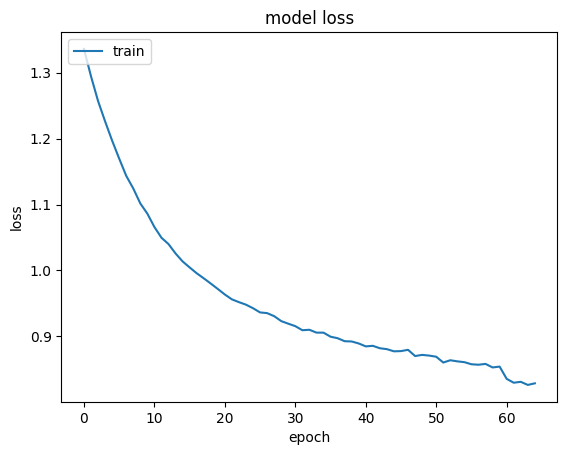

In [8]:
plt.plot(history.history["loss"][5:])
# plt.plot(history.history["val_loss"][5:])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [9]:
predictions = model.predict(x = X_train_array)
predictions

2514/2514 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


array([[4.2750937e-17, 1.9267524e-13, 1.1262137e-14, ..., 1.0229785e-01,
        4.0447861e-16, 8.7279344e-01],
       [1.6590844e-20, 9.0824028e-13, 1.8790343e-21, ..., 9.7110295e-01,
        1.7501278e-16, 2.8565258e-02],
       [3.9686867e-08, 5.5467581e-07, 2.4012836e-08, ..., 2.5172070e-01,
        1.7391540e-03, 6.2835813e-01],
       ...,
       [1.2100915e-12, 8.8494961e-11, 1.1329028e-09, ..., 4.0504031e-04,
        1.4595399e-05, 2.1733747e-07],
       [4.3737568e-06, 2.5500137e-07, 1.4516398e-14, ..., 1.0049050e-01,
        2.8988145e-02, 8.4537482e-01],
       [3.6781623e-20, 3.9486626e-22, 1.7134568e-19, ..., 7.1460046e-02,
        4.1337921e-03, 9.1999096e-01]], dtype=float32)

In [11]:
predicted_ratings = np.argmax(predictions, axis=1)

print(predicted_ratings.shape, predicted_ratings)
unique, counts = np.unique(predicted_ratings, return_counts=True)
# print(dict(zip(unique, counts)))
# train_data['rating'].value_counts()

# for (i, pred) in enumerate(predicted_ratings):
#     print(f"Predicted: {pred} Actual: {y_train_class[i]}")

def convert_rating(rating):
    return label_encoder.inverse_transform(rating)
    
converted_predicted_ratings = convert_rating(predicted_ratings)
converted_actual_ratings = convert_rating(y_train_class)

# for (i, pred) in enumerate(converted_predicted_ratings):
#     print(f"Predicted: {pred} Actual: {converted_actual_ratings[i]}")

correct, total = 0, 0
for (i, pred) in enumerate(converted_predicted_ratings):
    if pred == converted_actual_ratings[i]:
        correct += 1
    total += 1

print(f"Accuracy: {correct/total}")


(80419,) [9 7 9 ... 6 9 9]
Accuracy: 0.7855854959648839


# Item Recommendation

In [12]:
def unwatched_movies(ratings):
    all_movie_ids = set(ratings['movieId'])
    user_to_unwatched_movies = {}

    for user_id in ratings['userId'].unique():
        user = ratings[ratings['userId'] == user_id]
        watched_movies = set(user['movieId'])
        unwatched_movies = all_movie_ids - watched_movies
        user_to_unwatched_movies[user_id] = unwatched_movies

    return user_to_unwatched_movies

def recommend_movies(model, user_to_idx, movie_to_idx, n=10):
    unwatched = unwatched_movies(train_data)
    recommendations = {}

    for user_id, movies in unwatched.items():
        user_idx = user_to_idx[user_id]
        movie_indices = [movie_to_idx[movie_id] for movie_id in movies]
        
        user_array = np.array([user_idx] * len(movie_indices))
        movie_array = np.array(movie_indices)
        
        predictions = model.predict([user_array, movie_array])
        predicted_ratings = np.argmax(predictions, axis=1)
        
        top_n_movies = [movie for _, movie in sorted(zip(predicted_ratings, movies), reverse=True)[:n]]
        recommendations[user_id] = top_n_movies
        print(f"User {user_id}: {top_n_movies}")

    return recommendations

top_10_recommendations = recommend_movies(model, user_id_mapping, movie_id_mapping, n=10)

275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
User 1: [193609, 193587, 193585, 193583, 193579, 193573, 193567, 193565, 191005, 190221]
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step
User 2: [177593, 171763, 141718, 56171, 52328, 51931, 31364, 26810, 7121, 7025]
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
User 3: [187717, 184257, 182293, 180095, 179511, 179427, 177765, 177593, 176601, 175303]
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step
User 4: [193609, 190209, 189333, 188751, 188675, 187717, 187593, 185135, 184245, 183295]
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
User 5: [187593, 185135, 184245, 179133, 178827, 176601, 175397, 175387, 175293, 174551]
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
User 6: [193609, 193587, 193585, 193583, 193567, 193565, 191005, 190221, 190219, 190213]
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
User 7: [187593, 177593, 171763, 170705, 150548, 137859, 131724, 128520, 111759, 107999]
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
User 8: [193587, 193585, 193583, 193581, 193

In [13]:
def dcg(recommended_movies, actual_movies):
    dcg_value = 0.0
    for i, movie in enumerate(recommended_movies):
        if movie in actual_movies:
            dcg_value += 1 / np.log2(i + 2)  
    return dcg_value

def idcg(actual_movies, length):
    idcg_value = 0.0
    for i in range(min(len(actual_movies), length)):
        idcg_value += 1 / np.log2(i + 2)
    return idcg_value

def recommendation_performance(recommendations, test_data):
    running_precision, running_recall, running_ndcg = 0, 0, 0

    for user_id, recommended_movies in recommendations.items():
        actual_movies = test_data[test_data['userId'] == user_id]['movieId']

        intersection = len(set(recommended_movies) & set(actual_movies))
        precision = (intersection / len(recommended_movies)) * 100
        recall = (intersection / len(actual_movies)) * 100

        running_precision += precision
        running_recall += recall

        dcg_value = dcg(recommended_movies, actual_movies)
        idcg_value = idcg(actual_movies, len(recommended_movies))
        ndcg = (dcg_value / idcg_value) * 100 if idcg_value > 0 else 0
        running_ndcg += ndcg

    precision = running_precision / len(recommendations)
    recall = running_recall / len(recommendations)
    f_measure = 2 * (precision * recall) / (precision + recall)
    ndcg = running_ndcg / len(recommendations)

    return precision, recall, f_measure, ndcg

print("Precision \t%.4f%%\nRecall \t\t%.4f%%\nF-Measure \t%.4f%%\nNDCG \t\t%.4f%%" % recommendation_performance(top_10_recommendations, test_data))

Precision 	0.2131%
Recall 		0.0765%
F-Measure 	0.1126%
NDCG 		0.0000%
